Import Libraries

In [621]:
import argparse
import os
import random
import torch
import cv2
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from tqdm import tqdm
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader

In [622]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [623]:
mSeed = 99
random.seed(mSeed)
torch.manual_seed(mSeed)
torch.use_deterministic_algorithms


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
import os
current_directory = os.getcwd()
main_directory = os.path.abspath(os.path.join(current_directory, "../.."))
print(main_directory)

f:\SunsetPredictor


Import Weather Data     

In [ ]:
# Weather Data
weather_data  = pd.read_csv(main_directory + "/src/weather/data/golden_co/weather_data_interpolated.csv")
wColDrop = ['Unnamed: 0.1','Unnamed: 0']
weather_data.drop(columns=wColDrop, inplace=True)
new_column_names = {'{}'.format(col): 'weather_{}'.format(col) for col in weather_data.columns}
weather_data.rename(columns=new_column_names, inplace=True)
weather_data

,weather_date,weather_datetime,weather_temp,weather_feelslike,weather_humidity,weather_dew,weather_precip,weather_precipprob,weather_windspeed,weather_winddir,weather_pressure,weather_visibility,weather_cloudcover,weather_conditions,weather_icon,weather_moonphase
0,2005-01-01,16:00:00,39.8,32.9,48.2,21.8,0.000,0.0,11.3,110.0,1012.9,9.9,50.0,Partially cloudy,partly-cloudy-day,0.71
1,2005-01-02,16:00:00,32.1,32.1,65.5,21.8,0.000,0.0,2.2,280.0,1017.3,9.9,100.0,Overcast,cloudy,0.74
2,2005-01-03,16:00:00,38.9,35.3,57.2,25.1,0.000,0.0,4.9,60.0,1017.6,8.7,50.0,Partially cloudy,partly-cloudy-day,0.75
3,2005-01-04,16:00:00,11.9,3.1,92.3,10.1,0.051,100.0,5.3,50.0,1017.9,1.2,100.0,"Snow, Overcast",snow,0.81
4,2005-01-05,16:00:00,5.1,-7.7,78.5,-0.1,0.000,0.0,7.8,165.0,1014.9,9.9,90.0,Partially cloudy,partly-cloudy-day,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5839,2020-12-27,16:00:00,41.4,35.5,25.5,8.6,0.000,0.0,9.8,322.0,1015.1,9.9,62.6,Partially cloudy,partly-cloudy-day,0.42
5840,2020-12-28,16:00:00,29.2,29.2,87.9,26.1,0.000,0.0,1.3,4.0,1019.0,9.9,100.0,Overcast,cloudy,0.46
5841,2020-12-29,16:00:00,31.8,27.5,67.8,22.4,0.000,0.0,4.3,52.0,1016.0,9.9,19.3,Clear,clear-day,0.50
5842,2020-12-30,16:00:00,39.3,35.9,26.1,7.4,0.000,0.0,4.7,80.0,1017.0,9.9,19.3,Clear,clear-day,0.52


In [ ]:
# SunSet Time Data
SunsetTimedf =pd.read_csv(main_directory +'/ImageListwTimeDif.csv')
SunsetTimedf=SunsetTimedf.drop(SunsetTimedf.columns[0],axis=1)
SunsetTimedf['Date'] = SunsetTimedf['ImDate'].str.slice(0,10)
new_column_order = ['imgCode'] + [col for col in SunsetTimedf if col != 'imgCode']
SunsetTimedf = SunsetTimedf[new_column_order]
SunsetTimedf

,imgCode,ImDate,SunTime,TimeDif,Date
0,20051030165000.raw.jpg,2005-10-30 16:50:00,2005-10-30 17:02:40,-12.666667,2005-10-30
1,20051030164000.raw.jpg,2005-10-30 16:40:00,2005-10-30 17:02:40,-22.666667,2005-10-30
2,20051030163000.raw.jpg,2005-10-30 16:30:00,2005-10-30 17:02:40,-32.666667,2005-10-30
3,20051031165000.raw.jpg,2005-10-31 16:50:00,2005-10-31 17:01:28,-11.466667,2005-10-31
4,20051031164000.raw.jpg,2005-10-31 16:40:00,2005-10-31 17:01:28,-21.466667,2005-10-31
...,...,...,...,...,...
5162,20200201170000.raw.jpg,2020-02-01 17:00:00,2020-02-01 17:21:21,-21.350000,2020-02-01
5163,20200201165000.raw.jpg,2020-02-01 16:50:00,2020-02-01 17:21:21,-31.350000,2020-02-01
5164,20200202171000.raw.jpg,2020-02-02 17:10:00,2020-02-02 17:22:32,-12.533333,2020-02-02
5165,20200202170000.raw.jpg,2020-02-02 17:00:00,2020-02-02 17:22:32,-22.533333,2020-02-02


In [ ]:
# Combined Data
merged_df = pd.merge(SunsetTimedf, weather_data, left_on = "Date", right_on="weather_date", how = "left")
merged_df=merged_df.drop(columns=['Date', 'weather_date', 'weather_datetime','weather_icon'],axis=1)
merged_df = pd.get_dummies(merged_df,columns =['weather_conditions'], dtype = int)
# merged_df['imgCode'] = merged_df['imgCode'].apply(lambda x: main_directory + '/Data/SunSetImg/' + str(x))
SunSetArray  = merged_df.values
SunSetArray

array([['20051030165000.raw.jpg', '2005-10-30 16:50:00',
        '2005-10-30 17:02:40', ..., 0, 0, 0],
       ['20051030164000.raw.jpg', '2005-10-30 16:40:00',
        '2005-10-30 17:02:40', ..., 0, 0, 0],
       ['20051030163000.raw.jpg', '2005-10-30 16:30:00',
        '2005-10-30 17:02:40', ..., 0, 0, 0],
       ...,
       ['20200202171000.raw.jpg', '2020-02-02 17:10:00',
        '2020-02-02 17:22:32', ..., 0, 0, 0],
       ['20200202170000.raw.jpg', '2020-02-02 17:00:00',
        '2020-02-02 17:22:32', ..., 0, 0, 0],
       ['20200202165000.raw.jpg', '2020-02-02 16:50:00',
        '2020-02-02 17:22:32', ..., 0, 0, 0]], dtype=object)

In [ ]:
SunSetArray[1,:]

array(['20051030164000.raw.jpg', '2005-10-30 16:40:00',
       '2005-10-30 17:02:40', -22.66666666666663, 43.7, 39.4, 66.5, 33.3,
       0.007, 100.0, 7.4, 114.0, 1023.9, 8.1, 90.0, 0.93, 0, 0, 0, 0, 1,
       0, 0, 0], dtype=object)

In [ ]:
imgdirect =  main_directory + '/Data/SunSetImg/'

In [ ]:
from torchvision.io import read_image
from PIL import Image

In [ ]:
# Number of workers for dataloader
workers = 8

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, weather_file, img_dir, transform = None, target_transform = None):
        self.weather = weather_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.weather)
    
    def __getitem__(self, idx):
        tempWeather = self.weather[idx, 3:]
        tempWeather = tempWeather.astype(float)
        img_path = os.path.join(self.img_dir, self.weather[idx,0])
        image = read_image(img_path)
        weatherLabel = torch.from_numpy(tempWeather).float()


        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            weatherLabel = self.target_transform(weatherLabel)
        return image
    # , weatherLabel
    

In [ ]:
dataset = CustomImageDataset(SunSetArray, imgdirect, transform =transforms.Compose([
                               transforms.Resize(64)
                           ]))

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle= True)


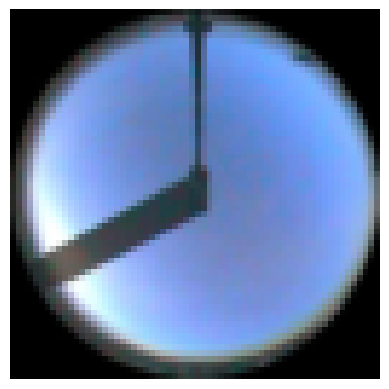

In [ ]:
import matplotlib.pyplot as plt

# Get the first batch of data from the DataLoader
images = next(iter(dataloader))
# print("Images type:", type(images))
# print("Labels type:", type(labels))
# Display the first image
plt.imshow(images[2].permute(1, 2, 0))  # permute to convert from (C, H, W) to (H, W, C) for visualization
# plt.title(labels[2])
plt.axis('off')
plt.show()


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``  
        )
        self.main2 = nn.Sequential(nn.Conv2d(ndf * 8, ndf * 8, 4, 1, 0, bias=False),
            nn.LeakyReLU())

    def forward(self, input):
        x = self.main(input)
        print(x.shape)
        x = self.main2(x)
        print(x.shape)
        return x

In [620]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main2): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_sl

In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
real_batch = next(iter(dataloader))


In [ ]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=False)
batch =next(iter(train_loader))

real_batch.shape

torch.Size([128, 3, 64, 64])

In [ ]:
# Training Loop
from tqdm import tqdm
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        real_cpu = real_cpu.type_as(netD.main[0].weight)
        # Convert input tensor to the same data type as the weights of the discriminator
        # print(real_cpu.shape)
        b_size = real_cpu.size(0)
        # print(b_size)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        # print(label.shape)
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([128, 512, 4, 4])


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


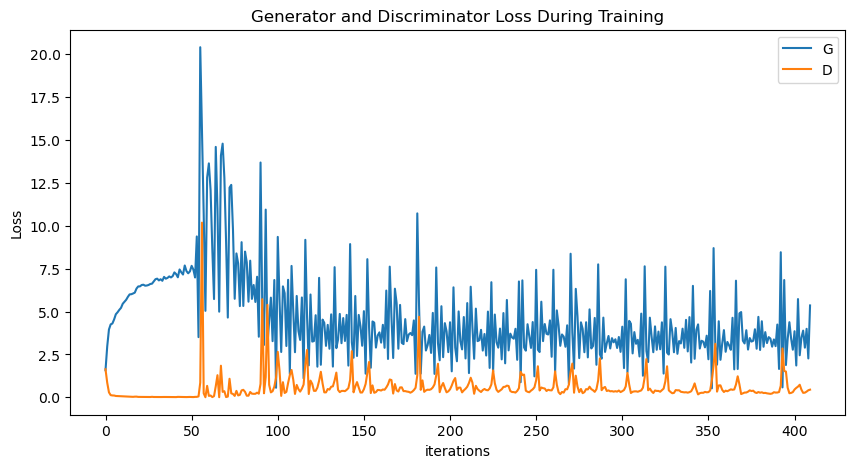

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

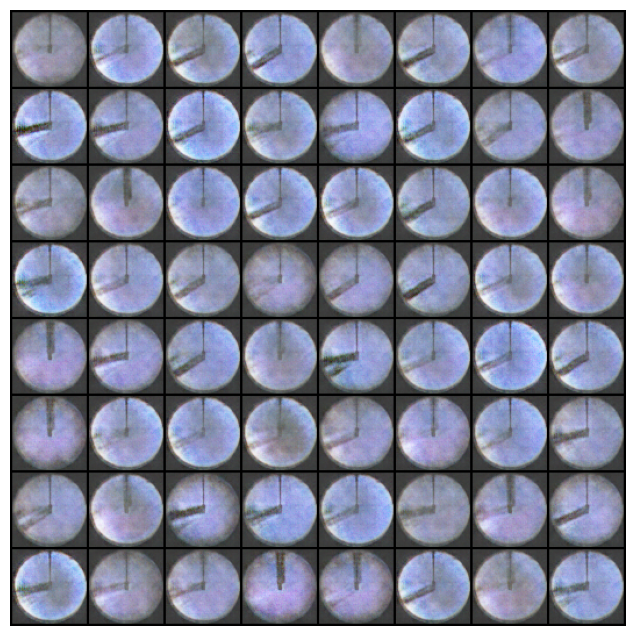

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())